In [1]:
from keras.layers import Input, Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.preprocessing import image
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import pandas as pd
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [2]:
! kaggle datasets download -d mahmoudreda55/satellite-image-classification

Dataset URL: https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification
License(s): copyright-authors
 73% 16.0M/21.8M [00:00<00:00, 167MB/s]
100% 21.8M/21.8M [00:00<00:00, 137MB/s]


In [3]:
from zipfile import ZipFile

# specifying the name of the zip file
file = "satellite-image-classification.zip"

# open the zip file in read mode
with ZipFile(file, 'r') as zip:
    # list all the contents of the zip file
    zip.printdir()

    # extract all files
    print('extraction...')
    zip.extractall()
    print('Done!')

Streaming output truncated to the last 5000 lines.
data/cloudy/train_23608.jpg                    2021-08-21 18:13:24         3700
data/cloudy/train_23634.jpg                    2021-08-21 18:13:24         4879
data/cloudy/train_23636.jpg                    2021-08-21 18:13:24         4605
data/cloudy/train_23646.jpg                    2021-08-21 18:13:24         7351
data/cloudy/train_2366.jpg                     2021-08-21 18:13:24         4664
data/cloudy/train_23664.jpg                    2021-08-21 18:13:24        15954
data/cloudy/train_23706.jpg                    2021-08-21 18:13:24         4999
data/cloudy/train_2380.jpg                     2021-08-21 18:13:24         5948
data/cloudy/train_23805.jpg                    2021-08-21 18:13:24         5034
data/cloudy/train_23806.jpg                    2021-08-21 18:13:24         2840
data/cloudy/train_23826.jpg                    2021-08-21 18:13:24        12071
data/cloudy/train_23843.jpg                    2021-08-21 18:13:24   

In [4]:
#show the shape of an instance image
img = cv2.imread("data/cloudy/train_10021.jpg")
img.shape

(256, 256, 3)

In [8]:
#make an image generator to form image dataset
data_gen=ImageDataGenerator(rescale=1./255,validation_split=0.2)


In [9]:
#make the train dataset using data generator
train_dataset=data_gen.flow_from_directory(directory="data",target_size=(128,128),batch_size=32,class_mode='categorical',subset='training')

Found 4505 images belonging to 4 classes.


In [11]:
#make the test dataset using data generator
test_dataset=data_gen.flow_from_directory(directory="data",target_size=(128,128),batch_size=32,class_mode='categorical',subset='validation')

Found 1126 images belonging to 4 classes.


In [10]:
#depict the classes label
train_dataset.class_indices

{'cloudy': 0, 'desert': 1, 'green_area': 2, 'water': 3}

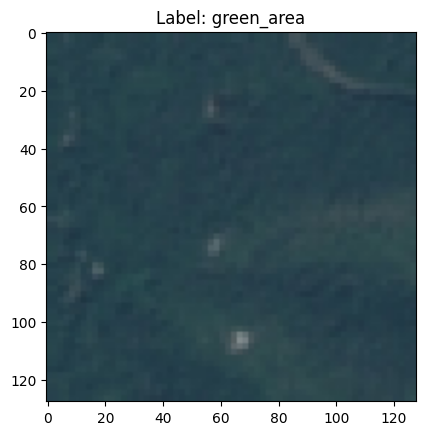

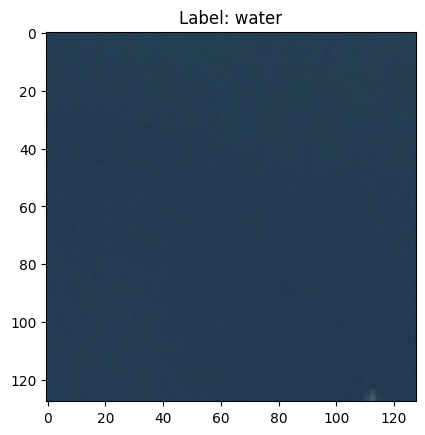

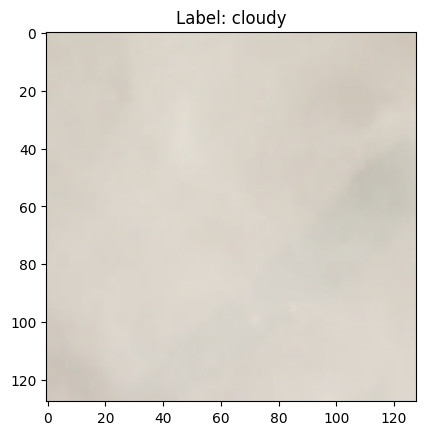

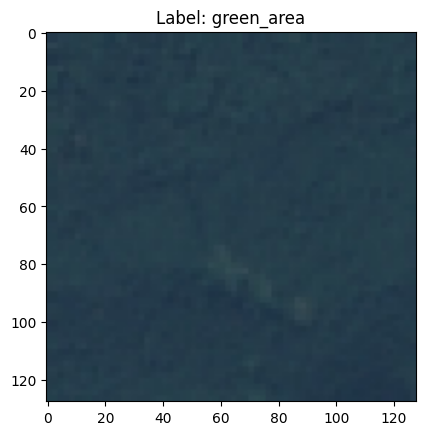

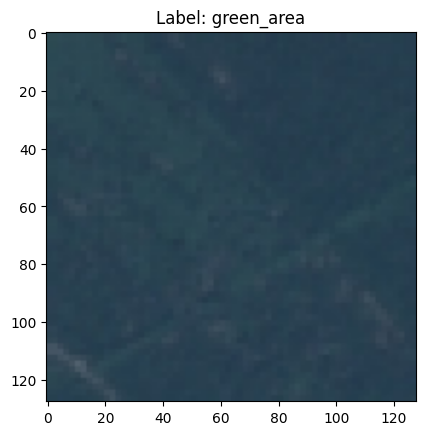

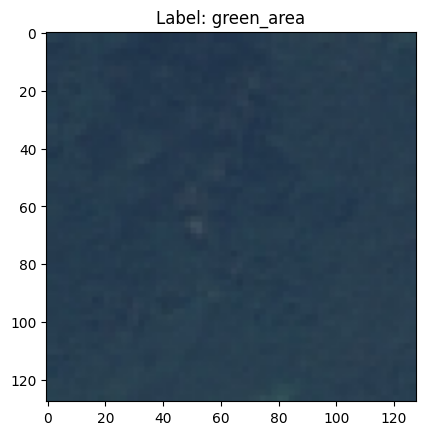

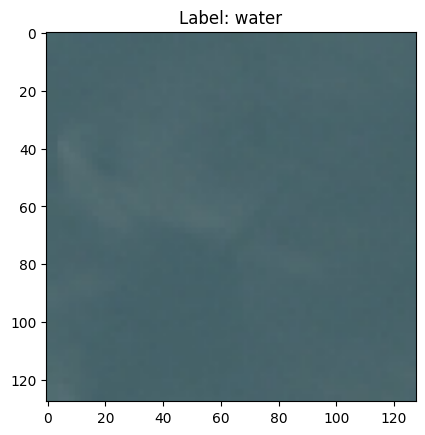

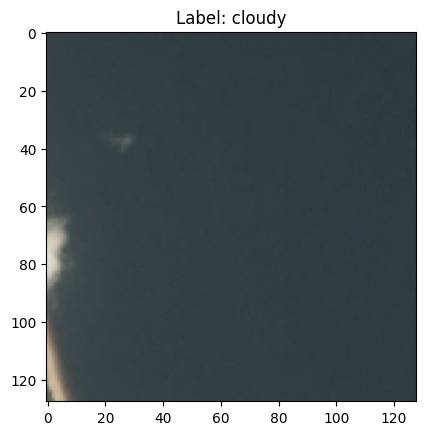

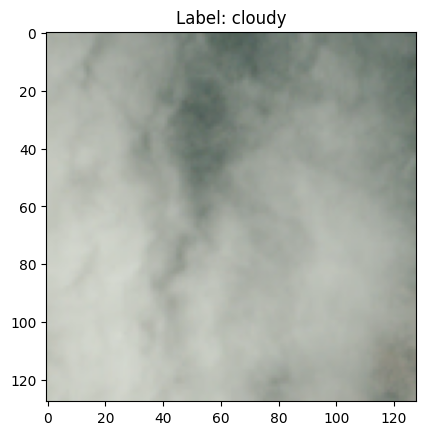

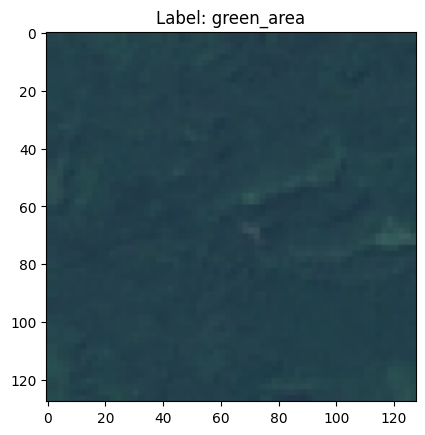

In [13]:
#  plot the ten of images in train datset  with true labels

import matplotlib.pyplot as plt

def plot_images_with_labels(dataset, num_images=10):
    """Plots images with their corresponding labels from a dataset.

    Args:
        dataset: A TensorFlow Dataset or Keras ImageDataGenerator object.
        num_images: The number of images to plot.
    """
    images, labels = next(dataset)
    class_indices = dataset.class_indices
    label_map = {v: k for k, v in class_indices.items()}

    for i in range(min(num_images, len(images))):
        plt.imshow(images[i])
        plt.title(f"Label: {label_map[np.argmax(labels[i])]}")
        plt.show()

# Assuming 'train_dataset' is your training dataset
plot_images_with_labels(train_dataset, num_images=10)

In [ ]:
#define the VGG-16 model
input = Input((128,128,3))

conv1  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(input)
conv2  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(conv1)
pool1  = MaxPooling2D((2, 2))(conv2)
conv3  = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(pool1)
conv4  = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(conv3)
pool2  = MaxPooling2D((2, 2))(conv4)

conv5  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(pool2)
conv6  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(conv5)
conv7  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(conv6)
pool3  = MaxPooling2D((2, 2))(conv7)
conv8  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool3)
conv9  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv8)
conv10 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv9)
pool4  = MaxPooling2D((2, 2))(conv10)

conv11 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool4)
conv12 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv11)
conv13 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv12)
pool5  = MaxPooling2D((2, 2))(conv13)
flat   = Flatten()(pool5)
dense1 = Dense(128, activation="relu")(flat)
dense2 = Dense(64, activation="relu")(dense1)
output = Dense(4, activation="softmax")(dense2)

vgg16_model  = Model(inputs=input, outputs=output)

In [ ]:
#show the model summary such as input and output size and the hidden layers
vgg16_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,771,908 (60.17 MB)

 Trainable params: 15,771,908 (60.17 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
vgg16_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
#use the 0.07 % of train data in each epoch as training sample
total_train_samples = len(train_dataset.filenames)  # Now get total number of samples
steps_per_epoch = int(total_train_samples * 0.07 / 32)  # steps_per_epoch = samples / batch_size
vgg16_model.fit(train_dataset, batch_size=32, epochs=10, validation_data=test_dataset,steps_per_epoch=steps_per_epoch)

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 393s 47s/step - accuracy: 0.4373 - loss: 0.7688 - val_accuracy: 0.5586 - val_loss: 0.7357
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 452s 54s/step - accuracy: 0.5186 - loss: 0.7374 - val_accuracy: 0.4849 - val_loss: 0.7995
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 395s 47s/step - accuracy: 0.4961 - loss: 0.8780 - val_accuracy: 0.5311 - val_loss: 0.8458
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 399s 47s/step - accuracy: 0.5483 - loss: 0.7972 - val_accuracy: 0.5311 - val_loss: 0.7649
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 394s 47s/step - accuracy: 0.5665 - loss: 0.7368 - val_accuracy: 0.5755 - val_loss: 0.7522
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 388s 46s/step - accuracy: 0.5886 - loss: 0.7190 - val_accuracy: 0.5346 - val_loss: 0.7554
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 393s 46s/step - accuracy: 0.5240 - loss: 0.7626 - val_accuracy: 0.5346 - val_loss: 0.7473
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 390s 46s/step - accuracy: 0.5666 - loss: 0.7341 - val_accuracy: 0.5195 - val_loss:

In [ ]:
#predict the test images
vgg16_model.predict(test_dataset)

36/36 ━━━━━━━━━━━━━━━━━━━━ 203s 6s/step


array([[0.05544678, 0.00389972, 0.5481254 , 0.39252815],
       [0.04920906, 0.00302312, 0.55809826, 0.3896695 ],
       [0.04918657, 0.00302017, 0.55813426, 0.389659  ],
       ...,
       [0.04918414, 0.00301985, 0.558138  , 0.38965797],
       [0.45931667, 0.1516909 , 0.16623874, 0.2227537 ],
       [0.04918888, 0.00302047, 0.55812985, 0.3896608 ]], dtype=float32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


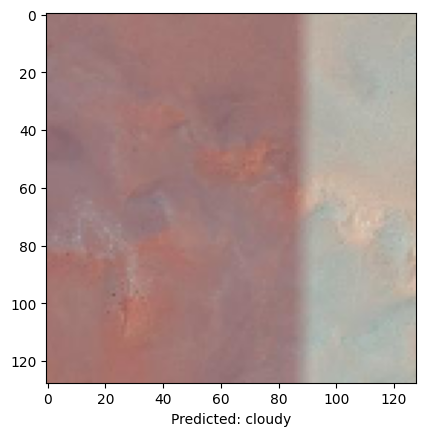

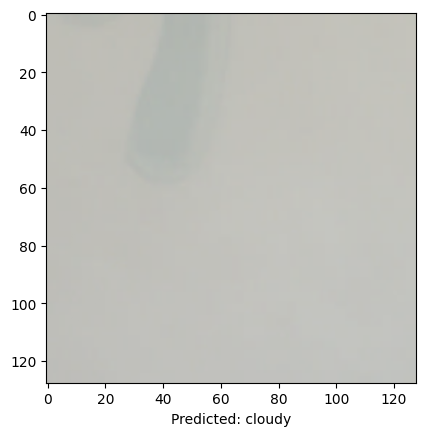

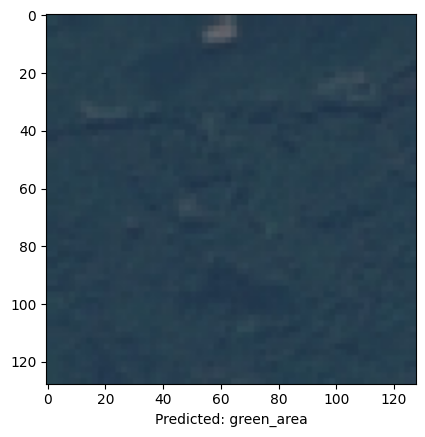

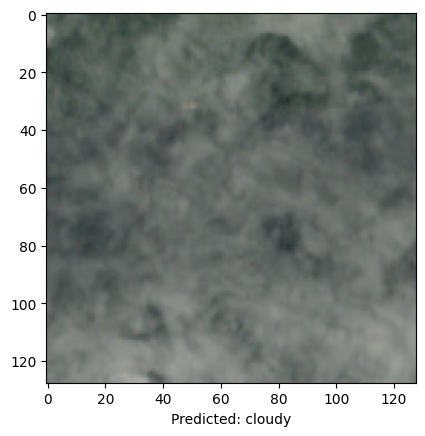

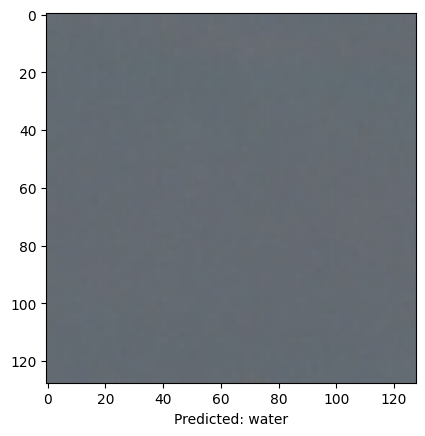

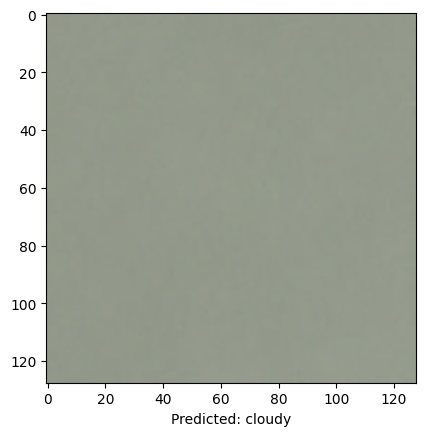

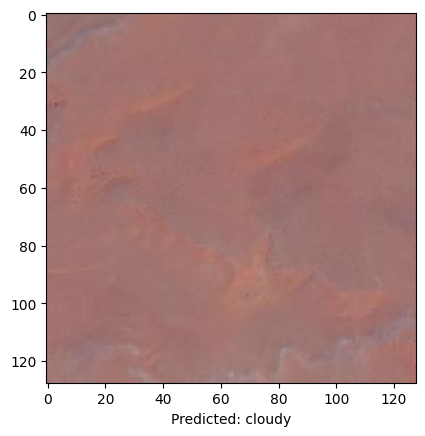

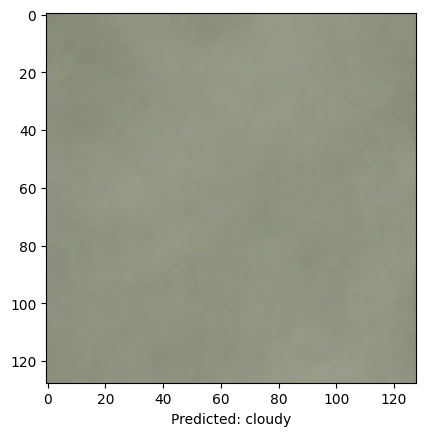

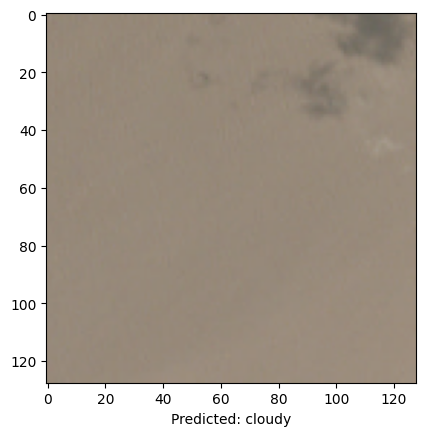

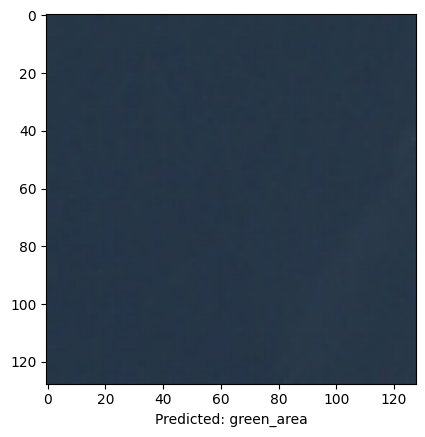

In [ ]:




# Get a batch of 10 images from the test dataset
num_samples = 10
test_batch = next(test_dataset)
images, labels = test_batch

# Predict the labels for the batch
predictions = vgg16_model.predict(images)

# Print the predicted labels and display the images
for i in range(num_samples):
  predicted_label = np.argmax(predictions[i])
  class_indices_reversed = {v: k for k, v in train_dataset.class_indices.items()}
  predicted_class = class_indices_reversed[predicted_label]

  plt.imshow(images[i])
  plt.xlabel(f"Predicted: {predicted_class}")
  plt.show()